In [12]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [14]:
# Download data
stock_data = yf.download("AAPL", start="2023-01-01", end="2024-01-01")
stock_data['Date'] = stock_data.index
stock_data['Days'] = (stock_data.index - stock_data.index[0]).days

[*********************100%***********************]  1 of 1 completed

In [15]:
# Features and target
X = stock_data['Days'].values.reshape(-1, 1)  # Days since start as feature
y = stock_data['Close'].values               # Closing price as target

In [16]:
# Split data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [17]:
# Decision Tree Regression
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)  # Adjust max_depth for complexity
tree_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, random_state=42)

In [18]:
# Predictions
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)


In [19]:
# Evaluate
print("Training MSE:", mean_squared_error(y_train, y_pred_train))
print("Testing MSE:", mean_squared_error(y_test, y_pred_test))
print("Training R2:", r2_score(y_train, y_pred_train))
print("Testing R2:", r2_score(y_test, y_pred_test))


Training MSE: 3.4451652359885374
Testing MSE: 147.76245644583142
Training R2: 0.9881950389584342
Testing R2: -0.8335609630930925


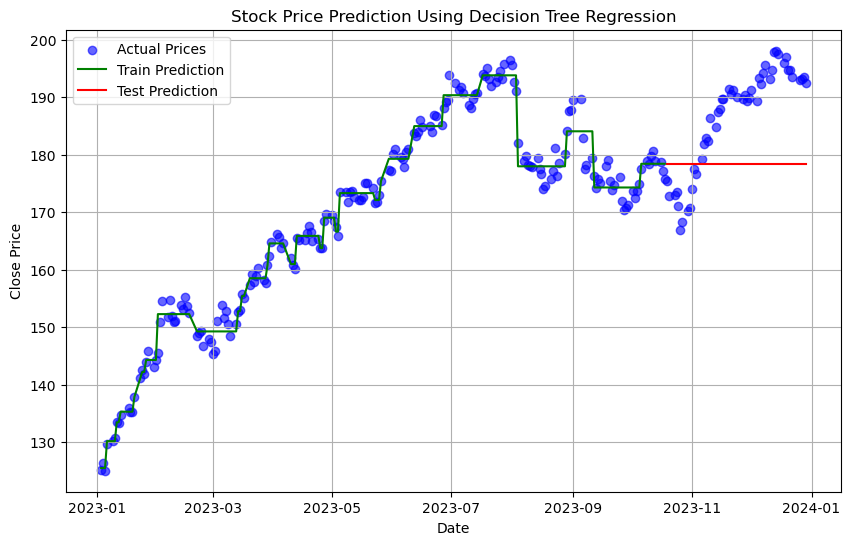

In [20]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(stock_data['Date'], y, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(stock_data['Date'][:split_index], y_pred_train, label='Train Prediction', color='green')
plt.plot(stock_data['Date'][split_index:], y_pred_test, label='Test Prediction', color='red')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Prediction Using Decision Tree Regression")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np

In [ ]:
# Initialize models and hyperparameter ranges for regression
models = {
    'LinearRegression': (LinearRegression(), {}),
    'DecisionTreeRegressor': (DecisionTreeRegressor(random_state=42), {'max_depth': [None, 5, 10, 15]}),
    'RandomForestRegressor': (RandomForestRegressor(random_state=42), {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10, 15]}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
}

model_results = {}
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define scoring metrics
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']


# Perform k-fold cross-validation for each model
for name, (model, params) in models.items():
    print(f"\nEvaluating Model: {name}")
    
    best_mean_cv_mse = float('inf')  # Lower is better for MSE
    best_mean_cv_mae = float('inf')
    best_mean_cv_r2 = float('-inf')  # Higher is better for R2
    best_params = None
    
    # Loop over each hyperparameter combination
    for param_combination in ParameterGrid(params):
        # Set parameters for the current model
        model.set_params(**param_combination)
        
        # Create a pipeline with a StandardScaler and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Perform cross-validation for each metric
        cv_scores = {}
        for metric in scoring_metrics:
            cv_scores[metric] = cross_val_score(pipeline, X, y, cv=kf, scoring=metric, n_jobs=-1)
        
        # Print scores for each metric
        for metric, scores in cv_scores.items():
            print(f"Parameters: {param_combination} => {metric}: {scores}")
        
        # Calculate mean scores for each metric
        mean_cv_mse = -np.mean(cv_scores['neg_mean_squared_error'])  # Convert to positive MSE
        mean_cv_mae = -np.mean(cv_scores['neg_mean_absolute_error'])  # Convert to positive MAE
        mean_cv_r2 = np.mean(cv_scores['r2'])
        
        # Update the best parameters based on MSE
        if mean_cv_mse < best_mean_cv_mse:
            best_mean_cv_mse = mean_cv_mse
            best_mean_cv_mae = mean_cv_mae
            best_mean_cv_r2 = mean_cv_r2
            best_params = param_combination
    
    # Save results for the model
    model_results[name] = {
        'Best Cross-Validation MSE': best_mean_cv_mse,
        'Best Cross-Validation MAE': best_mean_cv_mae,
        'Best Cross-Validation R2': best_mean_cv_r2,
        'Best Parameters': best_params
    }
    
    print(f"Best Cross-Validation Mean MSE: {best_mean_cv_mse:.2f}")
    print(f"Best Cross-Validation Mean MAE: {best_mean_cv_mae:.2f}")
    print(f"Best Cross-Validation Mean R2: {best_mean_cv_r2:.2f}")
    print(f"Best Parameters: {best_params}")

# Determine the best model based on cross-validation MSE
best_model_name = min(model_results, key=lambda model: model_results[model]['Best Cross-Validation MSE'])

print(f"\nBest Model: {best_model_name}")
print(f"Metrics: {model_results[best_model_name]}")



Evaluating Model: LinearRegression
Parameters: {} => neg_mean_squared_error: [ -94.67742948  -89.67304496 -127.75566754 -107.19743759  -88.03000028]
Parameters: {} => neg_mean_absolute_error: [-8.11361205 -7.11540594 -8.60639204 -8.42141646 -7.46048419]
Parameters: {} => r2: [0.70429483 0.64335171 0.6481765  0.65562751 0.61094307]
Best Cross-Validation Mean MSE: 101.47
Best Cross-Validation Mean MAE: 7.94
Best Cross-Validation Mean R2: 0.65
Best Parameters: {}

Evaluating Model: DecisionTreeRegressor
Parameters: {'max_depth': None} => neg_mean_squared_error: [-2.5221964  -5.75995923 -6.51232078 -5.74356728 -4.21876404]
Parameters: {'max_depth': None} => neg_mean_absolute_error: [-1.33200043 -1.76800018 -1.76299988 -1.92140091 -1.58240005]
Parameters: {'max_depth': None} => r2: [0.99212245 0.97709145 0.98206586 0.98154875 0.98135477]
Parameters: {'max_depth': 5} => neg_mean_squared_error: [ -9.4445556  -13.06953243 -10.47068798 -10.92892993  -8.40969501]
Parameters: {'max_depth': 5} =>